In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# !pip install --quiet missingno
# !pip install --quiet lightgbm
# !pip install bayesian-optimization
# !pip install scikit-optimize

In [1]:
import os
# os.chdir(r"/content/drive/MyDrive/billing_features/raw/")
import math
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import missingno as msno
import pickle
import lightgbm
import xgboost as xgb
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir=os.getcwd()
os.listdir()

['PolicyPremium_Combined.csv',
 'Data Dictionary v4.xlsx',
 'Trident_Data_Explore_0718.ipynb',
 'Anniv_RG_Data_POLICY_2017_2022YTD.txt',
 'Trident_Data_Explore_0708.ipynb',
 '01_feature_engineer.ipynb',
 'old_file',
 'churn_labels_update.csv',
 'churn_labels.csv',
 'Trident_Data_Explore_0715.ipynb']

In [3]:
start=time.time()
policy_premium_df = pd.read_csv(os.path.join(data_dir,'PolicyPremium_Combined.csv'))
end=time.time()
print("running time {:.4f}".format(end-start))
policy_premium_df.shape

running time 10.2551


(3626285, 25)

In [5]:
data_dir="/app/models/trident/retention/engineered_update"
# churn_labels = pd.read_csv('churn_labels_update.csv')
churn_labels = pd.read_csv(os.path.join(data_dir,'churn_labels.csv'))
churn_labels.dropna(subset=['churn'],inplace=True)
churn_labels.shape

(444055, 9)

In [6]:
policy_id=np.unique(churn_labels['policy_id'].values)
policy_id.shape

(119672,)

In [7]:
policy_premium_df=policy_premium_df[policy_premium_df["policy_id"].isin(policy_id)]
policy_premium_df.shape

(3625938, 25)

In [8]:
policy_premium_df['year']  = policy_premium_df.bill_due_dt.apply(lambda x: x[:4])
policy_premium_df['month'] = policy_premium_df.bill_due_dt.apply(lambda x: x[5:7])
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(str)
policy_premium_df['month']=policy_premium_df['month'].apply(str)
policy_premium_df.drop(['Unnamed: 0','report_start_dt','report_end_dt','bill_due_dt','bill_gen_dt'], axis=1, inplace=True)
policy_premium_df=policy_premium_df.reset_index(drop=True)

In [9]:
pd.set_option('display.max_columns', None)
policy_premium_df.loc[policy_premium_df.policy_id==607176].head()

,policy_id,CountBills,CountBillGens,CountFirstGenBillsPaidFull,CountBillsPaidFull,CountBillsPaid,OrigBillAmt,CurrBillAmt,CurrPaidAmt,PaidBillDueDays,AvgPdBilldueDays,PaidBillLastGenDays,AvgPdBillLstGenDays,AvgBillGenCnt,AvgPaidFullCnt,AvgFirstGenPaidFullCnt,Lag12_cntBillGens,Lag12_cntPaidFull,Lag12_cntFirstGenPaidFull,Lag12_cntBills,year,month
0,607176,1,1,1,1,1,211.31,211.31,211.31,-4,-4.0,14,14.0,1.0,1.0,1.0,13.0,12.0,11.0,12.0,2020,11
29022,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10.0,8,8.0,1.0,1.0,1.0,11.0,11.0,11.0,11.0,2018,12
40646,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10.0,8,8.0,1.0,1.0,1.0,8.0,8.0,8.0,8.0,2018,09
168812,607176,1,1,1,1,1,154.70,154.70,154.70,66,66.0,9,9.0,1.0,1.0,1.0,13.0,12.0,11.0,12.0,2020,03
174802,607176,1,1,1,1,1,190.98,190.98,190.98,-5,-5.0,13,13.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2018,01


In [10]:
policy_premium_df = policy_premium_df.replace('?', np.nan)
policy_premium_df["AvgPdBilldueDays"]=policy_premium_df["AvgPdBilldueDays"].astype(float)
policy_premium_df["AvgPdBillLstGenDays"]=policy_premium_df["AvgPdBillLstGenDays"].astype(float)
policy_premium_df["Lag12_cntBillGens"]=policy_premium_df["Lag12_cntBillGens"].astype(float)
policy_premium_df["Lag12_cntPaidFull"]=policy_premium_df["Lag12_cntPaidFull"].astype(float)
policy_premium_df["Lag12_cntFirstGenPaidFull"]=policy_premium_df["Lag12_cntFirstGenPaidFull"].astype(float)
policy_premium_df["Lag12_cntBills"]=policy_premium_df["Lag12_cntBills"].astype(float)

policy_premium_df['CountBills'] = policy_premium_df['CountBills'].replace(0, np.nan)
policy_premium_df['AvgPdBilldueDays'] = policy_premium_df['AvgPdBilldueDays'].replace(0, np.nan)
policy_premium_df['AvgPdBillLstGenDays'] = policy_premium_df['AvgPdBillLstGenDays'].replace(0, np.nan)
policy_premium_df['AvgBillGenCnt'] = policy_premium_df['AvgBillGenCnt'].replace(0, np.nan)
policy_premium_df['AvgPaidFullCnt'] = policy_premium_df['AvgPaidFullCnt'].replace(0, np.nan)

In [11]:
# policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

pd.set_option('display.max_columns', None,'display.max_rows', None)
tempt=pd.DataFrame(policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)).reset_index()
tempt=tempt[tempt[0]>0]
tempt.rename({"index":"variable",0:"missing %"},axis=1).style.format({"missing %":"{:.2%}"})

,variable,missing %
0,AvgPdBillLstGenDays,8.69%
1,AvgPdBilldueDays,5.06%
2,Lag12_cntBills,3.07%
3,Lag12_cntFirstGenPaidFull,3.07%
4,Lag12_cntPaidFull,3.07%
5,Lag12_cntBillGens,3.07%
6,AvgPaidFullCnt,2.76%


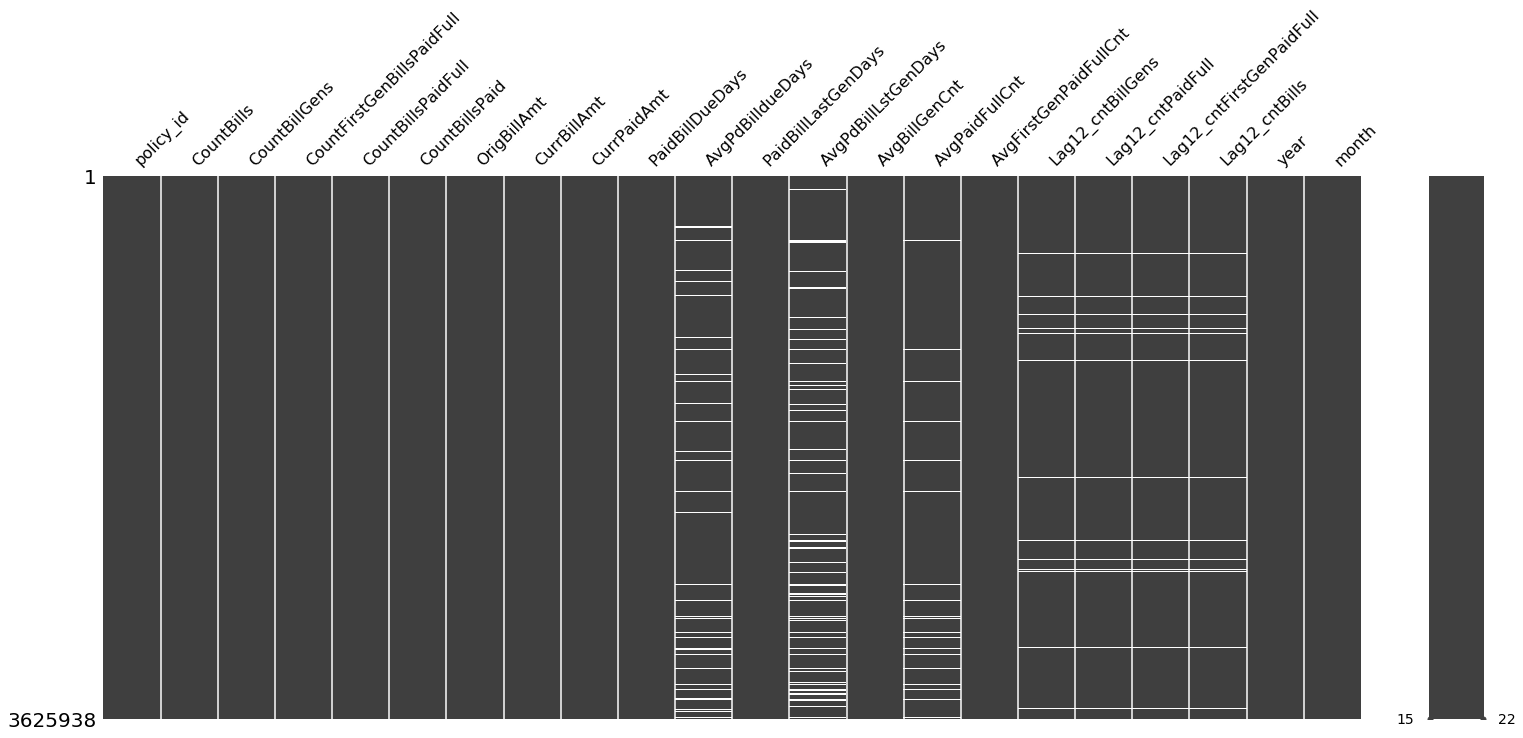

In [12]:
msno.matrix(policy_premium_df)

In [13]:
my_imputer = SimpleImputer()
numeric_columns=[]
categorical_columns=[]
for c in policy_premium_df.columns:
    if policy_premium_df[c].dtypes!="object":
        numeric_columns.append(c)
    else:
        categorical_columns.append(c)

data_numeric=policy_premium_df.loc[:,numeric_columns]
data_numeric=pd.DataFrame(my_imputer.fit_transform(data_numeric),columns=numeric_columns)

data_categorical=policy_premium_df.loc[:,categorical_columns]
policy_premium_df = pd.concat([data_numeric, data_categorical], axis = 1)

In [14]:
policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

policy_id                     0.0
CountBills                    0.0
year                          0.0
Lag12_cntBills                0.0
Lag12_cntFirstGenPaidFull     0.0
Lag12_cntPaidFull             0.0
Lag12_cntBillGens             0.0
AvgFirstGenPaidFullCnt        0.0
AvgPaidFullCnt                0.0
AvgBillGenCnt                 0.0
AvgPdBillLstGenDays           0.0
PaidBillLastGenDays           0.0
AvgPdBilldueDays              0.0
PaidBillDueDays               0.0
CurrPaidAmt                   0.0
CurrBillAmt                   0.0
OrigBillAmt                   0.0
CountBillsPaid                0.0
CountBillsPaidFull            0.0
CountFirstGenBillsPaidFull    0.0
CountBillGens                 0.0
month                         0.0
dtype: float64

In [15]:
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(int)
policy_premium_df['month']=policy_premium_df['month'].apply(int)

- $\frac{1}{T}\sum_{i=0}^{T}X_{t-i} \;\;\; T=1,2,3,6,12$
<br/><br/>
- $delta=X_t-X_{t-i} \;\;\; i=1,2,3,6,12$
<br/><br/>
- $ratio=\frac{X_t-X_{t-i}}{X_t} \;\;\; i=1,2,3,6,12$

In [16]:
def policy_df_accumulate(df):
    df.sort_values(['policy_id','year','month'],inplace=True)
    df["paid_bill_prop"]=df['CurrPaidAmt'].astype(float)/df['CurrBillAmt'].astype(float)
    # df["idx"]=df.groupby(['policy_id',"year"]).ngroup()
    exc_col=["policy_id","Lag12_cntBillGens","Lag12_cntPaidFull","Lag12_cntFirstGenPaidFull","Lag12_cntBills","year","month"]
    for col in tqdm(df.columns):
        if col not in exc_col:
            if col not in ["OrigBillAmt","CurrBillAmt","CurrPaidAmt","PaidBillDueDays","AvgPdBilldueDays","PaidBillLastGenDays","AvgPdBillLstGenDays","paid_bill_prop"]:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).sum()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).sum()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).sum()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).sum()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).sum()))
            else:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).mean()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).mean()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).mean()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).mean()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).mean()))  
                
#                 df["std12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).std()))
#                 df["std6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).std()))
#                 df["std1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).std()))
#                 df["std2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).std()))
#                 df["std3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).std()))
                
        if col not in ["policy_id","year","month"]:
            df["lag1_"+col]=df[col].shift(1)
            df["d1_"+col]=df[col]-df["lag1_"+col]
            df["r1_"+col]=(df[col]-df["lag1_"+col])/df["lag1_"+col]
            df.drop(["lag1_"+col],axis=1,inplace=True)
            
            df["lag2_"+col]=df[col].shift(2)
            df["d2_"+col]=df[col]-df["lag2_"+col]
            df["r2_"+col]=(df[col]-df["lag2_"+col])/df["lag2_"+col]
            df.drop(["lag2_"+col],axis=1,inplace=True)

            df["lag3_"+col]=df[col].shift(3)
            df["d3_"+col]=df[col]-df["lag3_"+col]
            df["r3_"+col]=(df[col]-df["lag3_"+col])/df["lag3_"+col]
            df.drop(["lag3_"+col],axis=1,inplace=True)
            
            df["lag6_"+col]=df[col].shift(6)
            df["d6_"+col]=df[col]-df["lag6_"+col]
            df["r6_"+col]=(df[col]-df["lag6_"+col])/df["lag6_"+col]
            df.drop(["lag6_"+col],axis=1,inplace=True)
            
            df["lag12_"+col]=df[col].shift(12)
            df["d12_"+col]=df[col]-df["lag12_"+col]
            df["r12_"+col]=(df[col]-df["lag12_"+col])/df["lag12_"+col]
            df.drop(["lag12_"+col],axis=1,inplace=True)
            
    # df.drop(['idx'],axis=1,inplace=True) 
               
    return df

In [17]:
df=policy_df_accumulate(policy_premium_df)

 65%|██████▌   | 15/23 [49:48<30:51, 231.43s/it]

In [ ]:
file_output="policy_premium_pickle"
data_dir="/app/models/dij22"
df.to_pickle(os.path.join(data_dir,file_output))

# file_output="policy_premium.csv"
# data_dir="/home/dij22/Trident"
# df.to_csv(os.path.join(data_dir,file_output))

In [4]:
file="policy_premium_pickle"
data_dir="/app/models/dij22"
policy_premium_df=pd.read_pickle(os.path.join(data_dir,file))

# start=time.time()
# file_output="policy_premium.csv"
# policy_premium_df=pd.read_csv(os.path.join(data_dir,file))
# end=time.time()
# print("running time {:.4f}".format(end-start))

In [5]:
pd.set_option('display.max_columns', None)
policy_premium_df.head()

,policy_id,CountBills,CountBillGens,CountFirstGenBillsPaidFull,CountBillsPaidFull,CountBillsPaid,OrigBillAmt,CurrBillAmt,CurrPaidAmt,PaidBillDueDays,AvgPdBilldueDays,PaidBillLastGenDays,AvgPdBillLstGenDays,AvgBillGenCnt,AvgPaidFullCnt,AvgFirstGenPaidFullCnt,Lag12_cntBillGens,Lag12_cntPaidFull,Lag12_cntFirstGenPaidFull,Lag12_cntBills,year,month,paid_bill_prop,L12_CountBills,L6_CountBills,L1_CountBills,L2_CountBills,L3_CountBills,d1_CountBills,r1_CountBills,d2_CountBills,r2_CountBills,d3_CountBills,r3_CountBills,d6_CountBills,r6_CountBills,d12_CountBills,r12_CountBills,L12_CountBillGens,L6_CountBillGens,L1_CountBillGens,L2_CountBillGens,L3_CountBillGens,d1_CountBillGens,r1_CountBillGens,d2_CountBillGens,r2_CountBillGens,d3_CountBillGens,r3_CountBillGens,d6_CountBillGens,r6_CountBillGens,d12_CountBillGens,r12_CountBillGens,L12_CountFirstGenBillsPaidFull,L6_CountFirstGenBillsPaidFull,L1_CountFirstGenBillsPaidFull,L2_CountFirstGenBillsPaidFull,L3_CountFirstGenBillsPaidFull,d1_CountFirstGenBillsPaidFull,r1_CountFirstGenBillsPaidFull,d2_CountFirstGenBillsPaidFull,r2_CountFirstGenBillsPaidFull,d3_CountFirstGenBillsPaidFull,r3_CountFirstGenBillsPaidFull,d6_CountFirstGenBillsPaidFull,r6_CountFirstGenBillsPaidFull,d12_CountFirstGenBillsPaidFull,r12_CountFirstGenBillsPaidFull,L12_CountBillsPaidFull,L6_CountBillsPaidFull,L1_CountBillsPaidFull,L2_CountBillsPaidFull,L3_CountBillsPaidFull,d1_CountBillsPaidFull,r1_CountBillsPaidFull,d2_CountBillsPaidFull,r2_CountBillsPaidFull,d3_CountBillsPaidFull,r3_CountBillsPaidFull,d6_CountBillsPaidFull,r6_CountBillsPaidFull,d12_CountBillsPaidFull,r12_CountBillsPaidFull,L12_CountBillsPaid,L6_CountBillsPaid,L1_CountBillsPaid,L2_CountBillsPaid,L3_CountBillsPaid,d1_CountBillsPaid,r1_CountBillsPaid,d2_CountBillsPaid,r2_CountBillsPaid,d3_CountBillsPaid,r3_CountBillsPaid,d6_CountBillsPaid,r6_CountBillsPaid,d12_CountBillsPaid,r12_CountBillsPaid,L12_OrigBillAmt,L6_OrigBillAmt,L1_OrigBillAmt,L2_OrigBillAmt,L3_OrigBillAmt,d1_OrigBillAmt,r1_OrigBillAmt,d2_OrigBillAmt,r2_OrigBillAmt,d3_OrigBillAmt,r3_OrigBillAmt,d6_OrigBillAmt,r6_OrigBillAmt,d12_OrigBillAmt,r12_OrigBillAmt,L12_CurrBillAmt,L6_CurrBillAmt,L1_CurrBillAmt,L2_CurrBillAmt,L3_CurrBillAmt,d1_CurrBillAmt,r1_CurrBillAmt,d2_CurrBillAmt,r2_CurrBillAmt,d3_CurrBillAmt,r3_CurrBillAmt,d6_CurrBillAmt,r6_CurrBillAmt,d12_CurrBillAmt,r12_CurrBillAmt,L12_CurrPaidAmt,L6_CurrPaidAmt,L1_CurrPaidAmt,L2_CurrPaidAmt,L3_CurrPaidAmt,d1_CurrPaidAmt,r1_CurrPaidAmt,d2_CurrPaidAmt,r2_CurrPaidAmt,d3_CurrPaidAmt,r3_CurrPaidAmt,d6_CurrPaidAmt,r6_CurrPaidAmt,d12_CurrPaidAmt,r12_CurrPaidAmt,L12_PaidBillDueDays,L6_PaidBillDueDays,L1_PaidBillDueDays,L2_PaidBillDueDays,L3_PaidBillDueDays,d1_PaidBillDueDays,r1_PaidBillDueDays,d2_PaidBillDueDays,r2_PaidBillDueDays,d3_PaidBillDueDays,r3_PaidBillDueDays,d6_PaidBillDueDays,r6_PaidBillDueDays,d12_PaidBillDueDays,r12_PaidBillDueDays,L12_AvgPdBilldueDays,L6_AvgPdBilldueDays,L1_AvgPdBilldueDays,L2_AvgPdBilldueDays,L3_AvgPdBilldueDays,d1_AvgPdBilldueDays,r1_AvgPdBilldueDays,d2_AvgPdBilldueDays,r2_AvgPdBilldueDays,d3_AvgPdBilldueDays,r3_AvgPdBilldueDays,d6_AvgPdBilldueDays,r6_AvgPdBilldueDays,d12_AvgPdBilldueDays,r12_AvgPdBilldueDays,L12_PaidBillLastGenDays,L6_PaidBillLastGenDays,L1_PaidBillLastGenDays,L2_PaidBillLastGenDays,L3_PaidBillLastGenDays,d1_PaidBillLastGenDays,r1_PaidBillLastGenDays,d2_PaidBillLastGenDays,r2_PaidBillLastGenDays,d3_PaidBillLastGenDays,r3_PaidBillLastGenDays,d6_PaidBillLastGenDays,r6_PaidBillLastGenDays,d12_PaidBillLastGenDays,r12_PaidBillLastGenDays,L12_AvgPdBillLstGenDays,L6_AvgPdBillLstGenDays,L1_AvgPdBillLstGenDays,L2_AvgPdBillLstGenDays,L3_AvgPdBillLstGenDays,d1_AvgPdBillLstGenDays,r1_AvgPdBillLstGenDays,d2_AvgPdBillLstGenDays,r2_AvgPdBillLstGenDays,d3_AvgPdBillLstGenDays,r3_AvgPdBillLstGenDays,d6_AvgPdBillLstGenDays,r6_AvgPdBillLstGenDays,d12_AvgPdBillLstGenDays,r12_AvgPdBillLstGenDays,L12_AvgBillGenCnt,L6_AvgBillGenCnt,L1_AvgBillGenCnt,L2_AvgBillGenCnt,L3_AvgBillGenCnt,d1_AvgBillGenCnt,r1_AvgBillGenCnt,d2_AvgBillGenCnt,r

In [6]:
policy_premium_df.shape

(3625938, 303)